In [36]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
# 加载数据
mem = Memory("./mycache")
@mem.cache
def get_data():
    data = load_svmlight_file("./data/housing_scale")
    return data[0],data[1]

X,y = get_data()
N,D = X.shape
print(N,D)
print(type(X))

506 13
<class 'scipy.sparse.csr.csr_matrix'>


In [38]:
# 分割训练集和验证集
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.4)
X_train = X_train.toarray()
X_val = X_val.toarray()
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
print(X_train[0])

[-0.998104  -0.6       -0.52346    1.        -0.674897  -0.0959954
  0.207003  -0.492966  -0.826087  -0.862595   0.276596   0.97196   -0.342163 ]


In [39]:
def forward(X,y=None,w=None,reg=None):
    N,d = X.shape
    res = {}
    score = X.dot(w.T)
    res['score'] = score
    if y is not None:
#         损失函数
        loss = (score - y)**2
#         正则化项
        reg_loss = 0.5 * reg * (np.sum(w**2))
        loss += reg_loss 
#         此处选择直接传回ｌｏｓｓ作为ｌｏｓｓ函数的导数，因为直接传回０或１效果不好，ｖａｌ会比ｔｅｓｔ效果好
        dloss = loss
        res['loss'] = 1.0/N * np.sum(loss)
        res['dloss'] = dloss
        res['cache'] = score - y
    return res

In [40]:
def backward(X,w,dloss,cache,reg,lr):
    N,d = X.shape
#     dscore
    dscore = dloss * 2 * cache
#     dw
    dw = np.dot(dscore.T,X)
    dw *= 1.0/N
    dw += reg * w
#     更新梯度
    w += -lr * dw
    return {'w':w}

In [41]:
def train(X_train,y_train=None,w=None,reg=None,lr=None):
    N,D = X_train.shape
    if w is None:
        w = np.random.randn(D).reshape(1,-1)
#         前向传播
    fw_res = forward(X_train,y_train,w,reg)
#     反向传播
    bw_res = backward(X_train,w,fw_res['dloss'],fw_res['cache'],reg=reg,lr=lr)
    return {'w':bw_res['w'],'loss':fw_res['loss'],'score':fw_res['score']}

In [42]:
def val(X_val,y_val,w,reg):
    N,D = X_val.shape
    fw_res = forward(X_val,y_val,w,reg)
    loss = fw_res['loss']
    return {'loss':loss,'score':fw_res['score']}

In [43]:
# 正则参数和学习率
reg_list = np.logspace(-4,1,num=6,base=10)
#reg_list = [0]
lr_list = np.logspace(-4,1,num=6,base=10)
#lr_list = [1e-2]

min_loss = 1000
best_reg = None
best_lr = None
best_w = None
best_train_loss_hist = None
best_val_loss_hist = None
best_train_socre_hist = None
best_val_score_hist = None
# 尝试不同的正则参数和学习率
for reg in reg_list:
    for lr in lr_list:
        train_loss_hist = []
        val_loss_hist = []
        train_score_hist = []
        val_score_hist = []
        w = None
        
        for i in range(50):
            train_res = train(X_train,y_train,w=w,reg=reg,lr=lr)
            w = train_res['w']
            train_loss_hist.append(train_res['loss'])
            train_score_hist.append(train_res['score'])
            
            val_res = val(X_val,y_val,w,reg=reg)
            val_loss_hist.append(val_res['loss'])
            val_score_hist.append(val_res['score'])

        cur_loss = val_loss_hist[-1]
        #print('-'*100)
        #print('loss:{},lr:{},reg:{}'.format(cur_loss,lr,reg))
        if cur_loss is not None and cur_loss < min_loss:
            min_loss = cur_loss
            best_lr = lr
            best_reg = reg
            best_w = w
            best_train_loss_hist = train_loss_hist
            best_val_loss_hist = val_loss_hist
            best_train_score_hist = train_score_hist[-1]
            best_val_score_hist = val_score_hist[-1]
            
print('*'*100)
print('min train loss:{},lr:{},reg:{}'.format(min_loss,best_lr,best_reg))

****************************************************************************************************
min train loss:57.66941223868114,lr:0.0001,reg:0.001


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


best w:[[ -7.42537836e+00  -2.86403495e+00  -9.06807010e-01  -2.50827449e+00
   -2.85136669e+00   5.42341211e+00   2.59313266e+00  -4.30632736e+00
   -2.24503298e-01  -1.10583025e+00   5.48369552e-03   6.72505771e+00
   -7.28442441e+00]] 
best_lr:0.0001 
best_reg:0.001
avg_train_loss:69.08793228488224,avg_val_loss:71.13043344770834


Text(0.5,1,'val_score vs y_val')

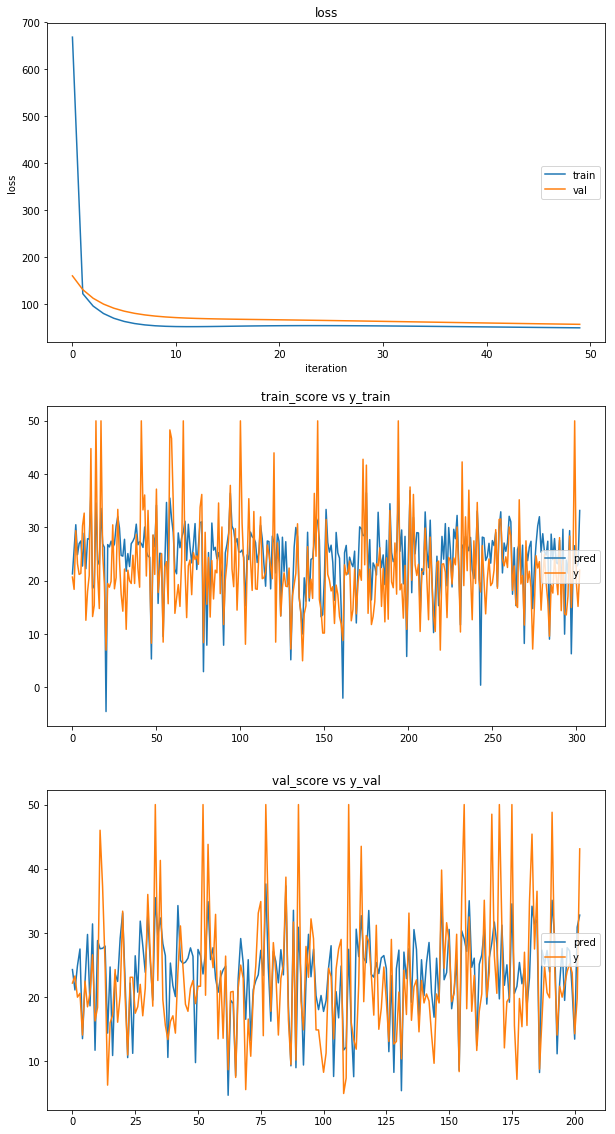

In [44]:
print('best w:{} \nbest_lr:{} \nbest_reg:{}'.format(best_w,best_lr,best_reg))
print('avg_train_loss:{},avg_val_loss:{}'.format(np.mean(best_train_loss_hist),np.mean(best_val_loss_hist)))

plt.rcParams['figure.figsize'] = (10.0, 20.0)

plt.subplot(3,1,1)
plt.plot(best_train_loss_hist[:])
plt.plot(best_val_loss_hist[:])
plt.xlabel('iteration')  
plt.ylabel('loss')  
plt.legend(['train','val'],loc='right')
plt.title('loss')

plt.subplot(3,1,2)
plt.plot(best_train_score_hist)
plt.plot(y_train)
plt.legend(['pred','y'],loc='right')
plt.title('train_score vs y_train')

plt.subplot(3,1,3)
plt.plot(best_val_score_hist)
plt.plot(y_val)
plt.legend(['pred','y'],loc='right')
plt.title('val_score vs y_val')